In [39]:
pip install ipynb >> None

Note: you may need to restart the kernel to use updated packages.


In [1]:
import import_ipynb

import numpy as np
import pandas as pd
import featuretools as ft
from featuretools import selection
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, roc_auc_score, make_scorer
from sklearn.pipeline import make_union, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



from category_encoders import OrdinalEncoder
from category_encoders.count import CountEncoder

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, mutual_info_classif

from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector
from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector

from ipynb.fs.full.cf_matrix_plot import make_confusion_matrix
from ipynb.fs.full.f_beta_loss import F_beta_loss

import seaborn as sns

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def f1_metric(y_true, y_pred):
    y_pred = np.round(y_pred)
    #return f1_score(y_true, y_pred)
    return ('f1', f1_score(y_true, y_pred), True)

In [3]:
not callable(f1_metric)

False

In [2]:
data = pd.read_csv('data_raw.csv')
data = data.drop(['Date.1', 'Date.2', 'Date.3'], axis=1)
data.shape

(7545, 513)

In [3]:
data.head()

,Date,^GSPC_Open,^GSPC_High,^GSPC_Low,^GSPC_Close,^GSPC_Adj Close,^GSPC_Volume,^GSPC_EMA_5,^GSPC_EMA_10,^GSPC_EMA_20,...,DX-Y.NYB Last Close 1,DX-Y.NYB Last Close 2,DX-Y.NYB Last Close 3,DX-Y.NYB Last Close 4,DX-Y.NYB Last Close 5,DX-Y.NYB Last Close 6,DX-Y.NYB Last Close 7,DX-Y.NYB Last Close 8,DX-Y.NYB Last Close 9,DX-Y.NYB Last Close 10
0,1993-01-29,438.670013,438.929993,436.910004,438.779999,438.779999,247200000,438.395204,437.498333,436.381358,...,91.279999,91.360001,90.550003,90.470001,91.410004,92.250000,91.550003,92.000000,92.059998,93.040001
1,1993-02-01,438.779999,442.519989,438.779999,442.519989,442.519989,238570000,439.770132,438.411362,436.965990,...,92.459999,91.279999,91.360001,90.550003,90.470001,91.410004,92.250000,91.550003,92.000000,92.059998
2,1993-02-02,442.519989,442.869995,440.760010,442.549988,442.549988,271560000,440.696751,439.163839,437.497799,...,93.559998,92.459999,91.279999,91.360001,90.550003,90.470001,91.410004,92.250000,91.550003,92.000000
3,1993-02-03,442.559998,447.350006,442.559998,447.200012,447.200012,345410000,442.864504,440.624961,438.421819,...,93.919998,93.559998,92.459999,91.279999,91.360001,90.550003,90.470001,91.410004,92.250000,91.550003
4,1993-02-04,447.200012,449.859985,447.200012,449.559998,449.559998,351140000,445.096336,442.249513,439.482598,...,94.239998,93.919998,93.559998,92.459999,91.279999,91.360001,90.550003,90.470001,91.410004,92.250000


In [4]:
#remove_low_information_features(feature_matrix)
#remove_highly_correlated_features(feature_matrix)
#remove_highly_null_features(feature_matrix)
#remove_single_value_features(feature_matrix)
filtered = selection.remove_highly_correlated_features(data, pct_corr_threshold=0.98)
filtered = selection.remove_low_information_features(filtered)
filtered = selection.remove_highly_null_features(filtered)
filtered = selection.remove_single_value_features(filtered)
filtered['^GSPC_High'] = data['^GSPC_High']
filtered['^GSPC_Low'] = data['^GSPC_Low']
filtered['^GSPC_Close'] = data['^GSPC_Close']
filtered = filtered.dropna()
filtered.head()

,Date,^GSPC_Open,^GSPC_Volume,^GSPC_SQZ_20_2.0_20_1.5,^GSPC_SQZ_ON,^GSPC_ABER_ATR_5_15,^GSPC_ADOSC_3_10,^GSPC_ADX_14,^GSPC_DMP_14,^GSPC_DMN_14,...,DX-Y.NYB_VHF_28,DX-Y.NYB level 5,DX-Y.NYB level 10,DX-Y.NYB level 20,DX-Y.NYB level 25,DX-Y.NYB level 30,DX-Y.NYB level 50,^GSPC_High,^GSPC_Low,^GSPC_Close
0,1993-01-29,438.670013,247200000,7.049998,False,2.902007,6.886895e+07,18.006061,28.075804,22.869827,...,0.244481,1.0,1.0,0.0,0.0,1.0,0.0,438.929993,436.910004,438.779999
1,1993-02-01,438.779999,238570000,7.881663,False,2.957872,1.703827e+08,18.460351,34.209112,20.804444,...,0.237145,0.0,0.0,0.0,0.0,0.0,0.0,442.519989,438.779999,442.519989
2,1993-02-02,442.519989,271560000,7.234996,False,2.901346,2.566182e+08,18.970118,33.292546,19.722291,...,0.260181,0.0,0.0,0.0,0.0,0.0,0.0,442.869995,440.760010,442.549988
3,1993-02-03,442.559998,345410000,7.144994,False,3.027924,3.715875e+08,20.417289,40.078885,17.493099,...,0.278434,1.0,0.0,0.0,0.0,0.0,0.0,447.350006,442.559998,447.200012
4,1993-02-04,447.200012,351140000,8.356664,False,3.003394,4.713655e+08,22.193214,43.509068,16.387681,...,0.316940,1.0,0.0,0.0,0.0,0.0,0.0,449.859985,447.200012,449.559998


In [5]:
filtered.shape, data.shape

((7534, 242), (7545, 513))

In [7]:
filtered.to_csv('filtered_features.csv')

In [17]:
filtered.columns.to_list()[2:]

['^GSPC_Volume',
 '^GSPC_SQZ_20_2.0_20_1.5',
 '^GSPC_SQZ_ON',
 '^GSPC_ABER_ATR_5_15',
 '^GSPC_ADOSC_3_10',
 '^GSPC_ADX_14',
 '^GSPC_DMP_14',
 '^GSPC_DMN_14',
 '^GSPC_AROOND_14',
 '^GSPC_AROONU_14',
 '^GSPC_AROONOSC_14',
 '^GSPC_BIAS_SMA_26',
 '^GSPC_BOP',
 '^GSPC_CCI_14_0.015',
 '^GSPC_CFO_9',
 '^GSPC_CG_10',
 '^GSPC_CMF_20',
 '^GSPC_CMO_14',
 '^GSPC_CTI_12',
 '^GSPC_DEC_1',
 '^GSPC_DPO_20',
 '^GSPC_EBSW_40_10',
 '^GSPC_EFI_13',
 '^GSPC_ENTP_10',
 '^GSPC_EOM_14_100000000',
 '^GSPC_ER_10',
 '^GSPC_BULLP_13',
 '^GSPC_BEARP_13',
 '^GSPC_FISHERT_9_1',
 '^GSPC_FISHERTs_9_1',
 '^GSPC_INERTIA_20_14',
 '^GSPC_KST_10_15_20_30_10_10_10_15',
 '^GSPC_KSTs_9',
 '^GSPC_MACD_12_26_9',
 '^GSPC_MACDh_12_26_9',
 '^GSPC_MACDs_12_26_9',
 '^GSPC_MASSI_9_25',
 '^GSPC_MFI_14',
 '^GSPC_MOM_10',
 '^GSPC_NATR_14',
 '^GSPC_PGO_14',
 '^GSPC_PSARaf_0.02_0.2',
 '^GSPC_PSARr_0.02_0.2',
 '^GSPC_PSL_12',
 '^GSPC_ROC_10',
 '^GSPC_THERMO_20_2_0.5',
 '^GSPC_THERMOl_20_2_0.5',
 '^GSPC_THERMOs_20_2_0.5',
 '^GSPC_TTM_TRND_6

In [6]:
y = filtered['target']
X = filtered.drop(['target'], axis=1)


In [7]:
y_final_test = y[-300:]
y = y[:-300]

X_final_test = X[X.shape[0] - 300 : X.shape[0]]
X = X[:X.shape[0] - 300]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False)

In [9]:
X_train.head()

,^GSPC_Open,^GSPC_Volume,^GSPC_SQZ_20_2.0_20_1.5,^GSPC_SQZ_ON,^GSPC_ABER_ATR_5_15,^GSPC_ADOSC_3_10,^GSPC_ADX_14,^GSPC_DMP_14,^GSPC_DMN_14,^GSPC_AROOND_14,...,DX-Y.NYB_THERMOs_20_2_0.5,DX-Y.NYB_TTM_TRND_6,DX-Y.NYB_UI_14,DX-Y.NYB_VHF_28,DX-Y.NYB level 5,DX-Y.NYB level 10,DX-Y.NYB level 20,DX-Y.NYB level 25,DX-Y.NYB level 30,DX-Y.NYB level 50
0,438.670013,247200000,7.049998,False,2.902007,6.886895e+07,18.006061,28.075804,22.869827,7.142857,...,True,1,1.816289,0.244481,1.0,1.0,0.0,0.0,1.0,0.0
1,438.779999,238570000,7.881663,False,2.957872,1.703827e+08,18.460351,34.209112,20.804444,0.000000,...,True,1,1.808961,0.237145,0.0,0.0,0.0,0.0,0.0,0.0
2,442.519989,271560000,7.234996,False,2.901346,2.566182e+08,18.970118,33.292546,19.722291,0.000000,...,True,1,1.792941,0.260181,0.0,0.0,0.0,0.0,0.0,0.0
3,442.559998,345410000,7.144994,False,3.027924,3.715875e+08,20.417289,40.078885,17.493099,35.714286,...,True,1,1.778286,0.278434,1.0,0.0,0.0,0.0,0.0,0.0
4,447.200012,351140000,8.356664,False,3.003394,4.713655e+08,22.193214,43.509068,16.387681,28.571429,...,True,1,1.774226,0.316940,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
class CorrSelector:
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        corr = np.absolute(np.corrcoef(X, rowvar=False))
        upper = corr*np.triu(np.ones(corr.shape), k=1).astype(np.bool)
        self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X):
        return np.delete(X, self.to_drop, axis=1)
    


[1]	valid_0's auc: 0.767635
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.807372
[3]	valid_0's auc: 0.823174
[4]	valid_0's auc: 0.830201
[5]	valid_0's auc: 0.847827
[6]	valid_0's auc: 0.863481
[7]	valid_0's auc: 0.868789
[8]	valid_0's auc: 0.87638
[9]	valid_0's auc: 0.880258
[10]	valid_0's auc: 0.886339
[11]	valid_0's auc: 0.893402
[12]	valid_0's auc: 0.897642
[13]	valid_0's auc: 0.902035
[14]	valid_0's auc: 0.907715
[15]	valid_0's auc: 0.913309
[16]	valid_0's auc: 0.915868
[17]	valid_0's auc: 0.918529
[18]	valid_0's auc: 0.923961
[19]	valid_0's auc: 0.930243
[20]	valid_0's auc: 0.933621
[21]	valid_0's auc: 0.935645
[22]	valid_0's auc: 0.937332
[23]	valid_0's auc: 0.939132
[24]	valid_0's auc: 0.941417
[25]	valid_0's auc: 0.94255
[26]	valid_0's auc: 0.94432
[27]	valid_0's auc: 0.945869
[28]	valid_0's auc: 0.947003
[29]	valid_0's auc: 0.947749
[30]	valid_0's auc: 0.949175
[31]	valid_0's auc: 0.949912
[32]	valid_0's auc: 0.951652
[33]	valid_0's auc: 0.9

C:\Users\Vitalij\AppData\Local\Temp\ipykernel_6960\3430518592.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr*np.triu(np.ones(corr.shape), k=1).astype(np.bool)
c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[1]	training's f1 beta: 0.8	valid_1's f1 beta: 0.8
[2]	training's f1 beta: 268255	valid_1's f1 beta: 267309
[3]	training's f1 beta: 268256	valid_1's f1 beta: 267638
[4]	training's f1 beta: 268257	valid_1's f1 beta: 268199
[5]	training's f1 beta: 268691	valid_1's f1 beta: 268691
[6]	training's f1 beta: 268810	valid_1's f1 beta: 268810
[7]	training's f1 beta: 268885	valid_1's f1 beta: 268885
[8]	training's f1 beta: 269987	valid_1's f1 beta: 269987
[9]	training's f1 beta: 269987	valid_1's f1 beta: 269987
[10]	training's f1 beta: 269988	valid_1's f1 beta: 269988
[11]	training's f1 beta: 269988	valid_1's f1 beta: 269988
[12]	training's f1 beta: 269989	valid_1's f1 beta: 269989
[13]	training's f1 beta: 269989	valid_1's f1 beta: 269989
[14]	training's f1 beta: 269989	valid_1's f1 beta: 269989
[15]	training's f1 beta: 269990	valid_1's f1 beta: 269990
[16]	training's f1 beta: 269990	valid_1's f1 beta: 269990
[17]	training's f1 beta: 269991	valid_1's f1 beta: 269991
[18]	training's f1 beta: 2699

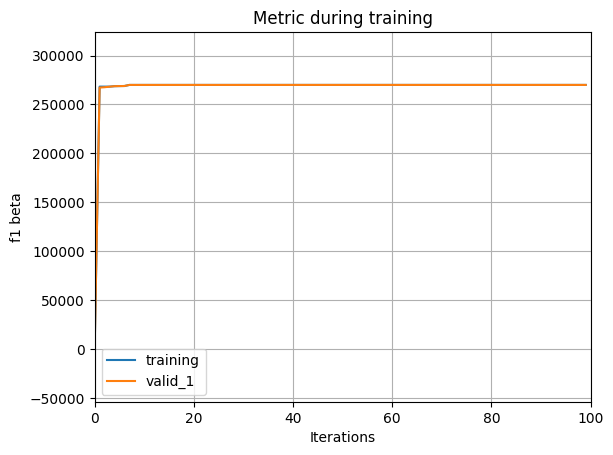

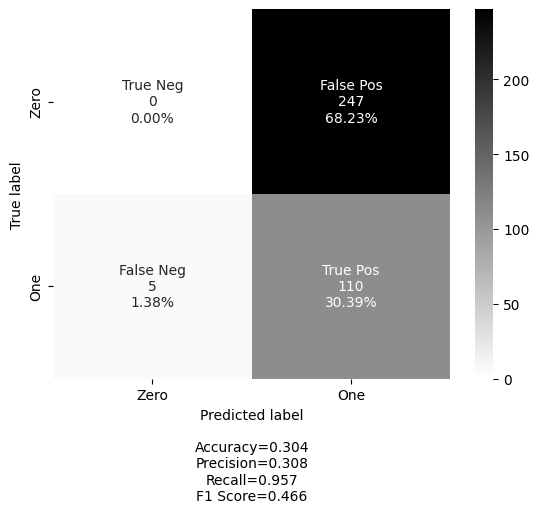

In [11]:
gbdt_features_to_select = 70
final_features = 50
beta = 0.2
fb = F_beta_loss(beta)

gbdt = GBDTSelector()
gbdt.fit(
    X_train,
    y_train,
    lgb_params={'boosting_type':'gbdt','metric': 'AUC','verbosity':-1},
    eval_ratio=0.25,
    early_stopping_rounds=10,
    importance_type='gain',
    num_boost_round=100
)
column_name = []

for i in gbdt.get_selected_features(gbdt_features_to_select):
    column_name.append(X_train.columns.to_list()[i])

evals = {}


X_train_first_filtered = X_train[column_name]
X_test_first_filtered = X_test[column_name]
print(X_train_first_filtered.shape)
correlated_pipeline = Pipeline([
('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
('correlated_remover', CorrSelector(.98)),
('mutual_info_remover', SelectPercentile(mutual_info_classif, percentile=98)),
('scaler', StandardScaler()),
('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False, random_state=42, max_iter=10000), max_features=final_features)),
#('feature_selection', SelectFromModel(LogisticRegression(penalty="l1",solver='liblinear'))),
#('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
#('classifier', LGBMClassifier())
]) 

train_cor = correlated_pipeline.fit_transform(X_train_first_filtered, y_train)
model = LGBMClassifier(learning_rate=0.4, n_estimators=100, objective=fb.lgb_obj, random_state=42, 
#early_stopping_round=5
)

model.fit(train_cor, y_train, 
eval_metric=fb.lgb_eval, 
eval_set=[(train_cor, y_train,), (correlated_pipeline.transform(X_test_first_filtered), y_test),],
#eval_set=[(train_cor, y_train),],
callbacks=[lgb.record_evaluation(evals)])
lgb.plot_metric(evals)
y_pred = model.predict(correlated_pipeline.transform(X_test_first_filtered))

#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))



labels = ['True Neg','False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']

cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 
                    group_names=labels,
                    categories=categories, 
                    cmap='binary')

In [14]:
train_cor.shape

(6872, 101)

In [15]:
scores = cross_val_score(
    LGBMClassifier(), train_cor, y_train, 
    cv=skf, scoring='f1_macro'
)
print('Cross-validated f1_macro: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

Cross-validated f1_macro: 0.925 +/- 0.011


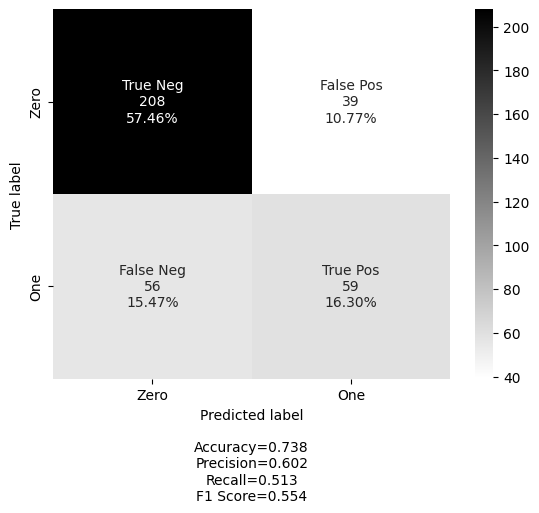

In [16]:
model = LGBMClassifier(learning_rate=0.4, n_estimators=100, objective='binary')

model.fit(train_cor, y_train, eval_metric=f1_metric)
y_pred = model.predict(correlated_pipeline.transform(X_test))
#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))


labels = ['True Neg','False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']

cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [50]:
from sklearn.feature_selection import RFECV

# svc = LinearSVC(penalty='l1', dual=False)
svc = LogisticRegression(penalty="l1",solver='liblinear')

rfecv = RFECV(estimator=svc, step=1, cv=skf, min_features_to_select=30,
              scoring='roc_auc', verbose=1)
rfecv.fit(X_train, y_train)

lgbm_pipeline = Pipeline([
    ('classifier', LGBMClassifier())
])

train_f_rfecv = rfecv.transform(X_train)


scores = cross_val_score(
    lgbm_pipeline, train_f_rfecv, y_train, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

Fitting estimator with 237 features.


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting estimator with 236 features.


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting estimator with 235 features.


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting estimator with 234 features.


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting estimator with 233 features.


c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting estimator with 232 features.


In [ ]:
model = LGBMClassifier()
model.fit(train_f_rfecv, y_train, eval_metric='AUC')
y_pred = model.predict(rfecv.transform(X_test))



cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [14]:
pip install eli5 >> None

Note: you may need to restart the kernel to use updated packages.


In [67]:
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
f1_scorer = make_scorer(f1_metric)

In [83]:
perm = PermutationImportance(LogisticRegression(penalty="l1", solver='liblinear'), scoring=f1_scorer, cv=None)
perm.fit(X_train, y_train.values)
perm_sel = SelectFromModel(perm, threshold=0.01, prefit=True)
train_f_perm = perm_sel.transform(X_train)

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [84]:
train_f_perm.shape

(6872, 69)

In [33]:
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
#     ('feature_selection', SelectFromModel(perm, threshold=0.05, prefit=False)),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train_f_perm, y_train, 
    cv=skf, scoring='f1'
)
print('Cross-validated f1: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

NameError: name 'train_f_perm' is not defined

c:\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


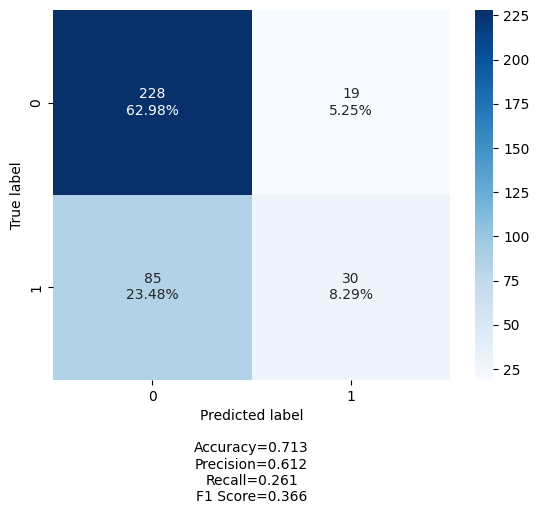

In [90]:

model = LGBMClassifier(learning_rate=0.4, n_estimators=100, objective='binary')
model.fit(train_f_perm, y_train, eval_metric=f1_score)
y_pred = model.predict(perm_sel.transform(X_test))

cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix)


In [78]:
print(len(y_pred))
print(len(y_test))

362
362


In [17]:
gbdt = GBDTSelector()
gbdt.fit(
    X_train,
    y_train,
    lgb_params={'boosting_type':'gbdt','metric':'AUC','verbosity':-1},
    eval_ratio=0.25,
    early_stopping_rounds=10,
    importance_type='gain',
    num_boost_round=100
)

[1]	valid_0's auc: 0.754868
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.78437
[3]	valid_0's auc: 0.805854
[4]	valid_0's auc: 0.818455
[5]	valid_0's auc: 0.824782
[6]	valid_0's auc: 0.827721
[7]	valid_0's auc: 0.844859
[8]	valid_0's auc: 0.854415
[9]	valid_0's auc: 0.860622
[10]	valid_0's auc: 0.87834
[11]	valid_0's auc: 0.882522
[12]	valid_0's auc: 0.885197
[13]	valid_0's auc: 0.892874
[14]	valid_0's auc: 0.900394
[15]	valid_0's auc: 0.907677
[16]	valid_0's auc: 0.908999
[17]	valid_0's auc: 0.912494
[18]	valid_0's auc: 0.917595
[19]	valid_0's auc: 0.921021
[20]	valid_0's auc: 0.924063
[21]	valid_0's auc: 0.925947
[22]	valid_0's auc: 0.928511
[23]	valid_0's auc: 0.930392
[24]	valid_0's auc: 0.935829
[25]	valid_0's auc: 0.937909
[26]	valid_0's auc: 0.939809
[27]	valid_0's auc: 0.942696
[28]	valid_0's auc: 0.94533
[29]	valid_0's auc: 0.945799
[30]	valid_0's auc: 0.947252
[31]	valid_0's auc: 0.948212
[32]	valid_0's auc: 0.949751
[33]	valid_0's auc: 0.9

In [28]:
column_name = []
for i in gbdt.get_selected_features(100):
    column_name.append(X_train.columns.to_list()[i])

In [29]:
train_f_gbdt = X_train[column_name]

In [30]:
column_name

['^GSPC_DPO_20',
 '^GSPC_MACD_12_26_9',
 '^IXIC_DMP_14',
 '^GSPC_Open',
 'DX-Y.NYB_Open',
 '^IXIC_ADX_14',
 'DX-Y.NYB_KSTs_9',
 '^VIX_SMA_200',
 '^GSPC % from high',
 'DX-Y.NYB_INERTIA_20_14',
 '^VIX_EMA_200',
 '^VIX_ADX_14',
 '^GSPC_KST_10_15_20_30_10_10_10_15',
 '^VIX_EMA_50',
 '^GSPC_ENTP_10',
 '^IXIC_UI_14',
 '^IXIC_NATR_14',
 'DX-Y.NYB_ADX_14',
 '^GSPC_ADX_14',
 '^GSPC_VHF_28',
 '^VIX_VHF_28',
 '^IXIC_ABER_ATR_5_15',
 'DX-Y.NYB_THERMOma_20_2_0.5',
 '^VIX_INERTIA_20_14',
 '^GSPC_DMN_14',
 '^IXIC_INERTIA_20_14',
 '^VIX_DMP_14',
 '^IXIC % from high',
 '^VIX_ACCBL_20',
 '^VIX_DMN_14',
 '^GSPC_NATR_14',
 'DX-Y.NYB_UI_14',
 '^IXIC_KST_10_15_20_30_10_10_10_15',
 '^VIX_KST_10_15_20_30_10_10_10_15',
 '^GSPC_ABER_ATR_5_15',
 '^IXIC_DPO_20',
 '^GSPC_CFO_9',
 '^GSPC_SQZ_20_2.0_20_1.5',
 '^VIX_ACCBU_20',
 '^VIX_MASSI_9_25',
 '^VIX_KSTs_9',
 '^VIX % from high',
 '^VIX_MACD_12_26_9',
 '^IXIC_MACDs_12_26_9',
 'DX-Y.NYB_KST_10_15_20_30_10_10_10_15',
 '^VIX_UI_14',
 '^IXIC_FISHERTs_9_1',
 'DX-Y.NYB

In [31]:
lgbm_pipeline = Pipeline([
    ('classifier', LGBMClassifier())
])


roc_scorer = make_scorer(roc_auc_score,needs_proba=True)
scores = cross_val_score(lgbm_pipeline, train_f_gbdt, y_train, 
                         cv=skf, scoring=roc_scorer)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

Cross-validated ROC_AUC: 0.986 +/- 0.003


              precision    recall  f1-score   support

       False       0.79      0.94      0.86       247
        True       0.77      0.47      0.58       115

    accuracy                           0.79       362
   macro avg       0.78      0.70      0.72       362
weighted avg       0.78      0.79      0.77       362

[[231  16]
 [ 61  54]]


<AxesSubplot: >

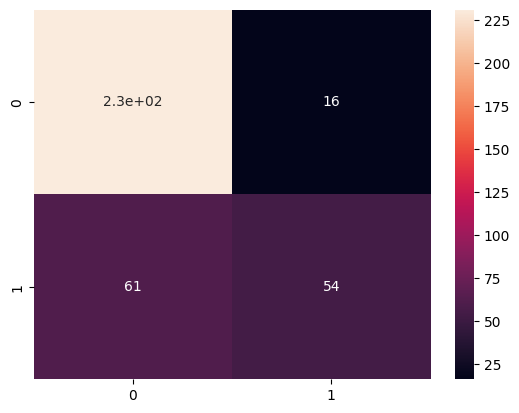

In [32]:
model = LGBMClassifier()
model.fit(train_f_gbdt , y_train, eval_metric='AUC')
y_pred = model.predict(X_test[column_name])
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)